In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
DATA_PATH = ""

dim_blocks = pd.read_csv(DATA_PATH + "dim_blocks_v1.csv", encoding='latin1')
fact_stores = pd.read_csv(DATA_PATH + "fact_stores_v1.csv", encoding='latin1')
fact_malls = pd.read_csv(DATA_PATH + "fact_malls_v1.csv", encoding='latin1')
store_financials = pd.read_csv(DATA_PATH + "store_financials_v1.csv", encoding='latin1')
cross_visits = pd.read_csv(DATA_PATH + "cross_visits_v1.csv", encoding='latin1')
sri_scores = pd.read_csv(DATA_PATH + "fact_sri_scores_v1.csv", encoding='latin1')
dim_malls = pd.read_csv(DATA_PATH + "dim_malls_v1.csv", encoding='latin1')
block_latest_gla = pd.read_csv(DATA_PATH + "block_latest_gla_v1.csv", encoding='latin1')

print("All datasets loaded successfully.")

# Inspecting the dataframes
dfs = {
    "fact_stores": fact_stores,
    "fact_malls": fact_malls,
    "store_financials": store_financials,
    "sri_scores": sri_scores,
    "dim_malls": dim_malls,
    "cross_visits": cross_visits,
    "dim_blocks": dim_blocks,
    "block_latest_gla": block_latest_gla
}

for name, df in dfs.items():
    print(f"--- {name} ---")
    print(df.head())
    print(df.info())
    print("\n")

All datasets loaded successfully.
--- fact_stores ---
         date  mall_id  block_id  store_code  retailer_id  people_in  \
0  01/07/2024       19      7064     1300441      50969.0        943   
1  01/07/2024        7      4844     1108435      88663.0         95   
2  01/07/2024       16      1671      600007        504.0        741   
3  01/07/2024       10      4564     1089312        711.0         97   
4  01/07/2024       16      1703     1306503     131720.0        342   

   people_window_flow  store_average_dwell_time  store_median_dwell_time  \
0               10797                 37.864189                34.045196   
1                3816                 33.365112                29.597769   
2               41704                  2.843237                 2.635919   
3                2180                  4.249951                 3.927536   
4                2591                 63.461003                58.833670   

   shopping_average_dwell_time  average_visited_stores  

**Data preprocessing**

In [ ]:
# Standardize column names
dfs['store_financials'].rename(columns={'codstr': 'store_code'}, inplace=True)
dfs['block_latest_gla'] = block_latest_gla.rename(columns={'ï»¿block_id': 'block_id'})
dfs['sri_scores'] = sri_scores.rename(columns={'ï»¿store_code ': 'store_code'})

# Convert date columns
for file in ['fact_stores', 'fact_malls']:
    dfs[file]['date'] = pd.to_datetime(dfs[file]['date'], dayfirst=True)

# Clean 'sales_r12m' in financials and convert to numeric
# Check for non-numeric characters first
def clean_numeric(val):
    if isinstance(val, str):
        val = val.replace(',', '').replace(' ', '')
    try:
        return float(val)
    except:
        return None

dfs['store_financials']['sales_r12m'] = dfs['store_financials']['sales_r12m'].apply(clean_numeric)

# Check for duplicates
duplicates = {}
for name, df in dfs.items():
    duplicates[name] = df.duplicated().sum()

# Check for missing values summary
missing_summary = {}
for name, df in dfs.items():
    missing_summary[name] = df.isnull().sum()

print("Duplicates count per file:")
print(duplicates)
print("\nMissing values summary:")
for name, missing in missing_summary.items():
    print(f"--- {name} ---")
    print(missing[missing > 0])
    print("\n")

# Store the cleaned dataframes back for easier reference
fact_stores = dfs['fact_stores']
fact_malls = dfs['fact_malls']
store_financials = dfs['store_financials']
sri_scores = dfs['sri_scores']
dim_malls = dfs['dim_malls']
# Removed: cross_visits = dfs['cross_visits'] as it's not modified here and exists globally
dim_blocks = dfs['dim_blocks']
block_latest_gla = dfs['block_latest_gla']

Duplicates count per file:
{'fact_stores': np.int64(0), 'fact_malls': np.int64(0), 'store_financials': np.int64(0), 'sri_scores': np.int64(0), 'dim_malls': np.int64(0), 'cross_visits': np.int64(0), 'dim_blocks': np.int64(43), 'block_latest_gla': np.int64(0)}

Missing values summary:
--- fact_stores ---
retailer_id                     4953
store_average_dwell_time       96870
store_median_dwell_time        96870
shopping_average_dwell_time    96870
average_visited_stores         96870
dtype: int64


--- fact_malls ---
people_in             12
average_dwell_time    22
dwell_time_sample     17
median_dwell_time     17
dtype: int64


--- store_financials ---
sales_r12m             2
total_costs_r12m    3683
dtype: int64


--- sri_scores ---
Series([], dtype: int64)


--- dim_malls ---
mall_name    19
dtype: int64


--- cross_visits ---
Series([], dtype: int64)


--- dim_blocks ---
store_name      3639
gla              143
gla_category     143
dtype: int64


--- block_latest_gla ---
latest_

In [ ]:
# Remove duplicates in dim_blocks
dim_blocks = dim_blocks.drop_duplicates()

# Drop rows with missing sales_r12m as there are only 2
store_financials = store_financials.dropna(subset=['sales_r12m'])

# Export cleaned files
#fact_stores.to_csv('cleaned_fact_stores.csv', index=False)
#fact_malls.to_csv('cleaned_fact_malls.csv', index=False)
#store_financials.to_csv('cleaned_store_financials.csv', index=False)
#sri_scores.to_csv('cleaned_fact_sri_scores.csv', index=False)
#dim_malls.to_csv('cleaned_dim_malls.csv', index=False)
#cross_visits.to_csv('cleaned_cross_visits.csv', index=False)
#dim_blocks.to_csv('cleaned_dim_blocks.csv', index=False)
#block_latest_gla.to_csv('cleaned_block_gla.csv', index=False)

# Let's create a summary of the store-level data for the user
store_info = dim_blocks.merge(store_financials, on='store_code', how='left')
store_info = store_info.merge(sri_scores, on='store_code', how='left')

print("Store Info Merged Head:")
#print(store_info.head())
#print("\nStore Info Info:")
print(store_info.info())

store_info.to_csv('store_master_data.csv', index=False)

Store Info Merged Head:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4096 entries, 0 to 4095
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mall_id           4096 non-null   int64  
 1   block_id          4096 non-null   int64  
 2   block_type        4096 non-null   object 
 3   store_code        4096 non-null   int64  
 4   store_name        500 non-null    object 
 5   retailer_code     4096 non-null   int64  
 6   bl1_label         4096 non-null   object 
 7   bl2_label         4096 non-null   object 
 8   bl3_label         4096 non-null   object 
 9   gla               3953 non-null   float64
 10  gla_category      3953 non-null   object 
 11  cur_code          3845 non-null   object 
 12  sales_r12m        3845 non-null   float64
 13  total_costs_r12m  3057 non-null   float64
 14  sri_score         1887 non-null   float64
dtypes: float64(4), int64(4), object(7)
memory usage: 480.1+ KB
None


In [ ]:
# Patch missing GLA in dim_blocks
dim_blocks_patched = dim_blocks.copy()
# Create a mapping from block_id to latest_gla
gla_map = block_latest_gla.set_index('block_id')['latest_gla'].to_dict()

# Apply the patch where gla is null
dim_blocks_patched.loc[dim_blocks_patched['gla'].isnull(), 'gla'] = dim_blocks_patched['block_id'].map(gla_map)

# Recalculate missing GLA count
remaining_missing_gla = dim_blocks_patched['gla'].isnull().sum()
print(f"Remaining missing GLA after patch: {remaining_missing_gla}")

# --- Currency Conversion for store_financials (added to ensure EUR columns exist) ---
fx_rates = {
    'EUR': 1.0,
    'DKK': 0.134,
    'SEK': 0.087,
    'PLN': 0.23,
    'CZK': 0.040,
    'GBP': 1.20,
    'USD': 0.92
}

# Ensure numeric types before conversion (already done in zfKqq4SnXQV7 but good to be explicit)
# Assuming 'sales_r12m' and 'total_costs_r12m' are already cleaned and converted to numeric in previous steps
store_financials['sales_r12m_eur'] = store_financials.apply(lambda row: row['sales_r12m'] * fx_rates.get(row['cur_code'], 1.0), axis=1)
store_financials['total_costs_r12m_eur'] = store_financials.apply(lambda row: row['total_costs_r12m'] * fx_rates.get(row['cur_code'], 1.0), axis=1)

# Final master update with patched GLA and currency conversion
store_info_patched = dim_blocks_patched.merge(store_financials, on='store_code', how='left')
# Corrected: Use 'sri_scores' as it has been cleaned and renamed, not 'fact_sri_scores'
store_info_patched = store_info_patched.merge(sri_scores, on='store_code', how='left')

# Calculate Sales density (EUR / sqm)
store_info_patched['sales_density'] = store_info_patched['sales_r12m_eur'] / store_info_patched['gla']

store_info_patched.to_csv('store_master_data_v3.csv', index=False)
print("Updated master data with sales density saved.")

Remaining missing GLA after patch: 70
Updated master data with sales density saved.


/tmp/ipython-input-789604294.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store_financials['sales_r12m_eur'] = store_financials.apply(lambda row: row['sales_r12m'] * fx_rates.get(row['cur_code'], 1.0), axis=1)
/tmp/ipython-input-789604294.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store_financials['total_costs_r12m_eur'] = store_financials.apply(lambda row: row['total_costs_r12m'] * fx_rates.get(row['cur_code'], 1.0), axis=1)


**Exploratory Data Analysis (EDA)**

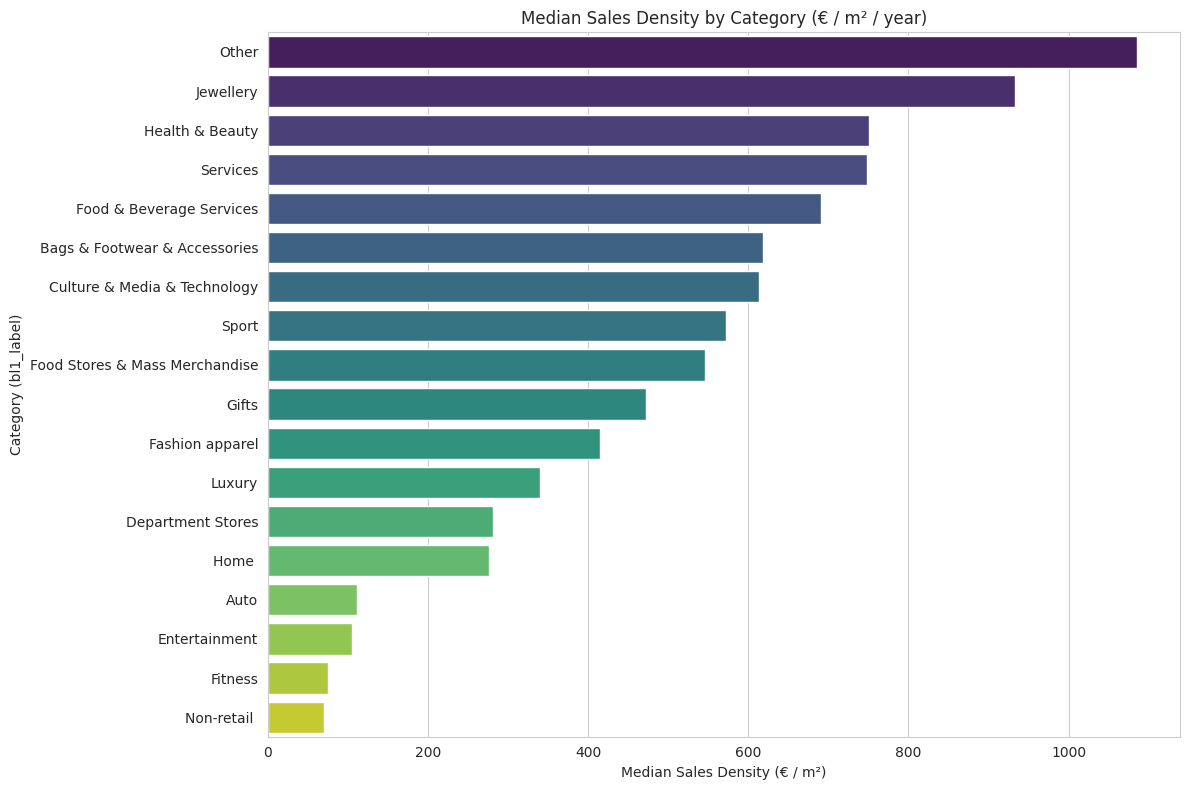

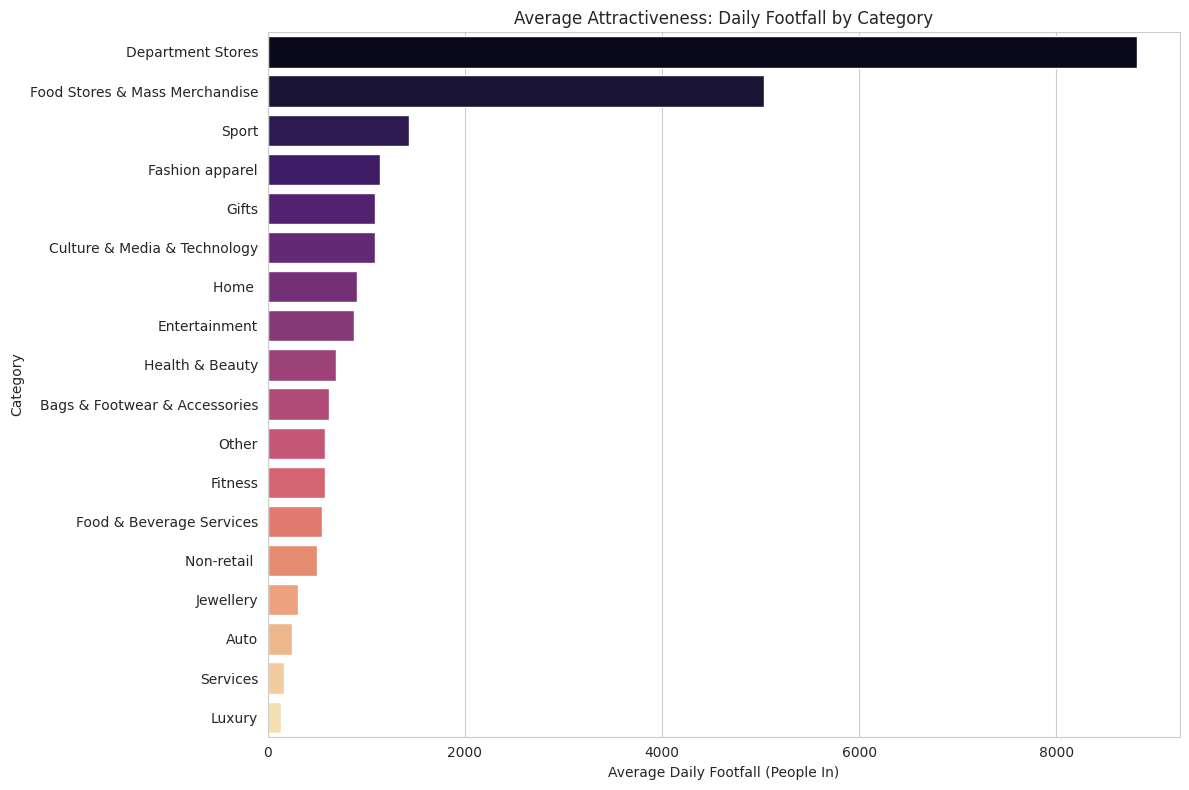

In [ ]:
# Load the master data (v3)
store_master = pd.read_csv('store_master_data_v3.csv')

# 1. Sales Density by Category (bl1_label)
# Filter out rows where sales_density is null or inf
category_stats = store_master[store_master['sales_density'].notnull() & (store_master['sales_density'] != float('inf'))]

# Group by category
agg_stats = category_stats.groupby('bl1_label').agg(
    avg_sales_density=('sales_density', 'mean'),
    median_sales_density=('sales_density', 'median'),
    total_sales_eur=('sales_r12m_eur', 'sum'),
    store_count=('store_code', 'count')
).reset_index()

# Sort by median sales density for the plot
agg_stats = agg_stats.sort_values(by='median_sales_density', ascending=False)

# 2. Visualization
plt.figure(figsize=(12, 8))
sns.barplot(data=agg_stats, y='bl1_label', x='median_sales_density', hue='bl1_label', palette='viridis', legend=False)
plt.title('Median Sales Density by Category (€ / m² / year)')
plt.xlabel('Median Sales Density (€ / m²)')
plt.ylabel('Category (bl1_label)')
plt.tight_layout()
plt.savefig('sales_density_by_category.png')

# 3. Attractiveness by Category
# Need to merge with fact_stores to get people_in
# Since fact_stores is daily, we'll sum/average people_in per store_code first
store_traffic = fact_stores.groupby('store_code')['people_in'].mean().reset_index()
store_traffic.rename(columns={'people_in': 'avg_daily_entries'}, inplace=True)

# Merge back to master
store_master_traffic = store_master.merge(store_traffic, on='store_code', how='left')

category_traffic = store_master_traffic.groupby('bl1_label')['avg_daily_entries'].mean().reset_index().sort_values(by='avg_daily_entries', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=category_traffic, y='bl1_label', x='avg_daily_entries', hue='bl1_label', palette='magma', legend=False)
plt.title('Average Attractiveness: Daily Footfall by Category')
plt.xlabel('Average Daily Footfall (People In)')
plt.ylabel('Category')
plt.tight_layout()
plt.savefig('attractiveness_by_category.png')

# print("Category Statistics Table:")
# print(agg_stats)

# print("\nTraffic Statistics Table:")
# print(category_traffic)

Voici une première analyse stratégique basée sur les données nettoyées pour orienter votre réflexion sur le "Retail Mix" optimal :

1. Performance par Catégorie : Densité de Vente (€/m²)
La Densité de Vente (médiane) nous indique quelles catégories rentabilisent le mieux l'espace loué.

Top Rentabilité (Espace) : Les Bijouteries (Jewellery) et les produits de Santé & Beauté (Health & Beauty) dominent. Ils génèrent énormément de chiffre d'affaires sur de petites surfaces.

Performance Solide : La Restauration (Food & Beverage Services) et les Services affichent des densités élevées (~700-750 €/m²), confirmant leur rôle central dans les centres modernes.

Défi de l'Espace : La Mode (Fashion apparel), bien qu'étant le plus gros contributeur en volume total (347M €), a une densité médiane plus faible (~414 €/m²). Cela s'explique par les grandes surfaces occupées par les enseignes "ancres".

2. Attractivité : Flux de Visiteurs (Entries)
L'Attractivité mesure la capacité d'une catégorie à faire entrer les gens dans le magasin.

Les Moteurs de Flux (Anchors) : Les Grands Magasins (Department Stores) et l'Alimentaire (Food Stores & Mass Merchandise) sont les véritables aimants du centre avec respectivement 8800 et 5000 entrées quotidiennes en moyenne.

Le Sport : Se distingue comme une catégorie "destination" forte (1430 entrées/jour).

Le paradoxe Restauration / Beauté : Ces catégories ont des flux d'entrées plus faibles (~500-700) mais une densité de vente très élevée. Cela suggère un taux de conversion (achats par visite) très efficace.

3. Pistes pour le "Retail Mix de Demain"
En croisant ces deux graphiques, on peut identifier des opportunités :

Optimisation de l'Espace : Réduire les surfaces de catégories à faible densité (Home, Auto) au profit de concepts "Boutiques" (Santé/Beauté) ou de Services.

Synergies : Placer les boutiques à haute densité (Bijouterie) sur les chemins menant aux ancres (Alimentaire/Grands Magasins) pour capter le flux massif.

Que souhaitez-vous approfondir ?

Analyse des Taux de Capture : Voir quel % des gens passant devant une boutique décident d'y entrer.

Analyse des Cross-Visits : Quelles boutiques les gens visitent-ils ensemble ? (Idéal pour le zoning/placement).

Focus sur un Centre spécifique : Analyser un mall en particulier pour voir s'il est "équilibré" par rapport à la moyenne.

                         bl1_label  median_density  median_entries  \
15                           Other     1084.961064      437.238562   
12                       Jewellery      933.431219      200.998037   
10                 Health & Beauty      750.732511      207.950139   
16                        Services      748.704576      117.121324   
7         Food & Beverage Services      695.801333      381.857143   
1    Bags & Footwear & Accessories      618.827145      459.788439   
2     Culture & Media & Technology      613.252801      364.858086   
17                           Sport      572.607310     1049.490000   
8   Food Stores & Mass Merchandise      545.433636     3317.124772   
9                            Gifts      472.822765     1091.538462   
5                  Fashion apparel      414.816892      406.608696   
13                          Luxury      340.152650      106.326780   
3                Department Stores      281.357363     5184.717033   
11                  

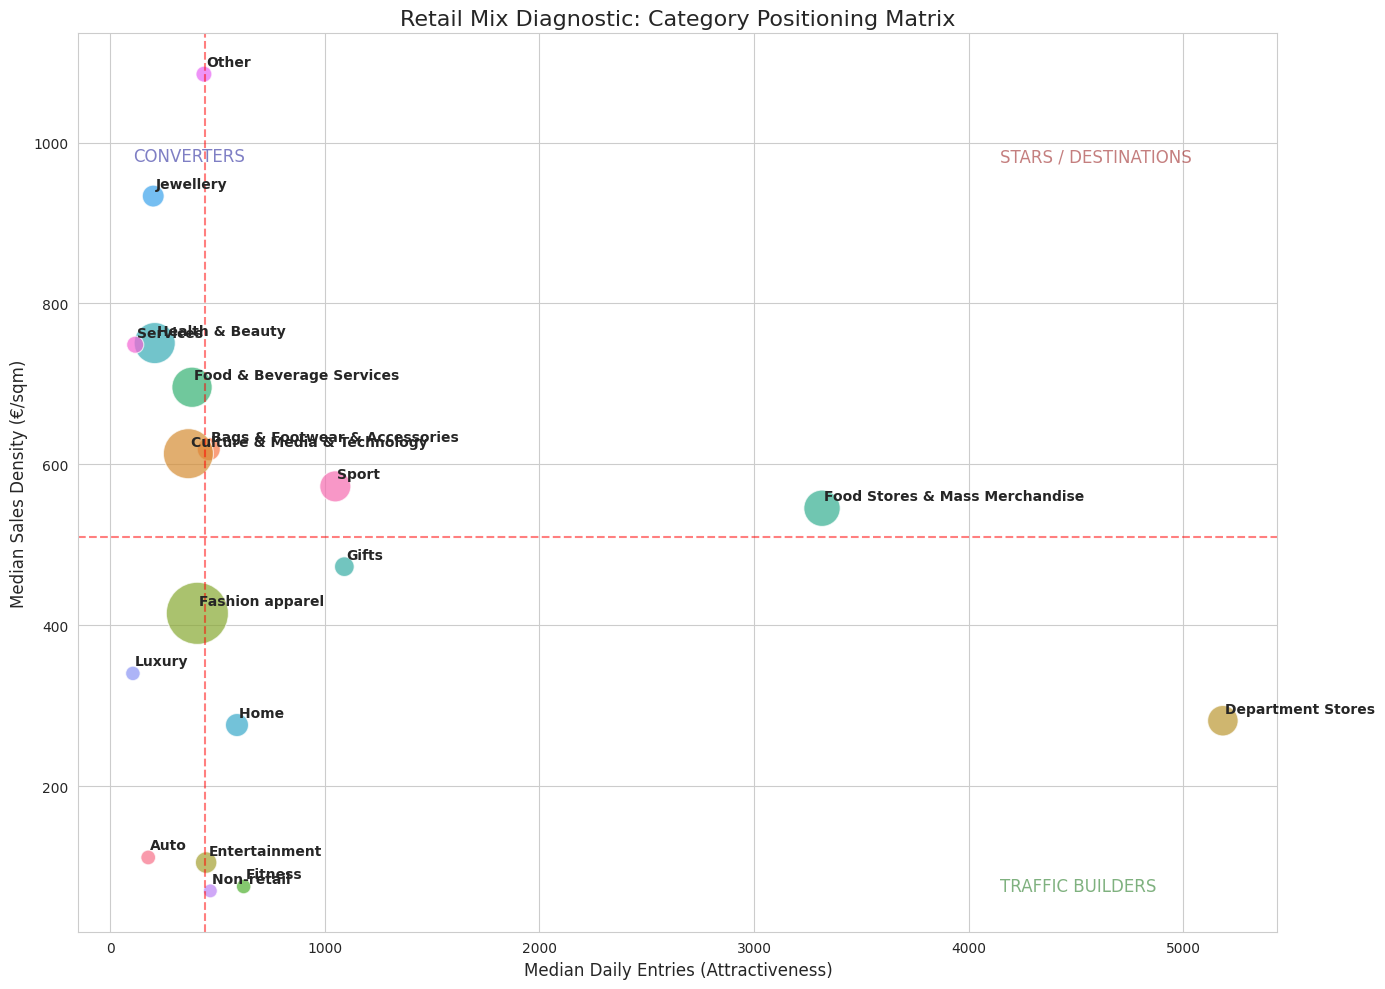

In [ ]:
# 1. Prepare traffic metrics per store
store_traffic_metrics = fact_stores.groupby('store_code').agg(
    avg_daily_in=('people_in', 'mean'),
    avg_daily_flow=('people_window_flow', 'mean')
).reset_index()

# Calculate capture rate (avoid division by zero)
store_traffic_metrics['capture_rate'] = (store_traffic_metrics['avg_daily_in'] / store_traffic_metrics['avg_daily_flow']).replace([float('inf'), -float('inf')], 0).fillna(0)

# 2. Merge with Master Data
store_master = pd.read_csv('store_master_data_v3.csv')
diagnostic_df = store_master.merge(store_traffic_metrics, on='store_code', how='left')

# 3. Aggregate by Category (bl1_label)
category_positioning = diagnostic_df.groupby('bl1_label').agg(
    median_density=('sales_density', 'median'),
    median_entries=('avg_daily_in', 'median'),
    avg_capture_rate=('capture_rate', 'mean'),
    total_sales_eur=('sales_r12m_eur', 'sum'),
    store_count=('store_code', 'count')
).reset_index()

# Remove categories with missing crucial data
category_positioning = category_positioning.dropna(subset=['median_density', 'median_entries'])

# 4. Create the Positioning Matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 10))
sns.set_style("whitegrid")

# Bubble chart
scatter = sns.scatterplot(
    data=category_positioning,
    x='median_entries',
    y='median_density',
    size='total_sales_eur',
    hue='bl1_label',
    sizes=(100, 2000),
    alpha=0.7,
    legend=False
)

# Add labels to points
for i in range(category_positioning.shape[0]):
    plt.text(
        category_positioning.median_entries[i]+10,
        category_positioning.median_density[i]+10,
        category_positioning.bl1_label[i],
        fontsize=10,
        weight='semibold'
    )

# Add quadrant lines (using medians of medians)
plt.axhline(category_positioning['median_density'].median(), color='red', linestyle='--', alpha=0.5)
plt.axvline(category_positioning['median_entries'].median(), color='red', linestyle='--', alpha=0.5)

# Annotate quadrants
plt.text(category_positioning['median_entries'].max()*0.8, category_positioning['median_density'].max()*0.9, 'STARS / DESTINATIONS', color='darkred', alpha=0.5, fontsize=12)
plt.text(category_positioning['median_entries'].min(), category_positioning['median_density'].max()*0.9, 'CONVERTERS', color='darkblue', alpha=0.5, fontsize=12)
plt.text(category_positioning['median_entries'].max()*0.8, category_positioning['median_density'].min(), 'TRAFFIC BUILDERS', color='darkgreen', alpha=0.5, fontsize=12)

plt.title('Retail Mix Diagnostic: Category Positioning Matrix', fontsize=16)
plt.xlabel('Median Daily Entries (Attractiveness)', fontsize=12)
plt.ylabel('Median Sales Density (€/sqm)', fontsize=12)
plt.tight_layout()
plt.savefig('retail_mix_positioning_matrix.png')

# Save the diagnostic table
category_positioning.to_csv('category_positioning_diagnostic.csv', index=False)

print(category_positioning.sort_values(by='median_density', ascending=False))

👉 Chaque bulle a une taille proportionnelle à total_sales_eur, qui est calculé comme :

Ce diagnostic de positionnement du Retail Mix croise deux dimensions fondamentales : l'Attractivité (capacité à attirer du flux) et la Performance Economique (capacité à monétiser l'espace).

Matrice de Positionnement Stratégique
La matrice divise vos catégories en 4 quadrants clés :

1. Les "Stars" & Destinations (Haut flux / Haute densité)
Sport & Culture : Ces catégories réussissent l'équilibre parfait. Elles attirent massivement (flux élevé) tout en maintenant une excellente rentabilité au m².

Food Stores & Mass Merchandise : Bien que ce soient des ancres, elles conservent une densité de vente solide grâce à la fréquence d'achat élevée.

2. Les "Converters" (Faible flux / Haute densité)
Jewellery (Bijouterie), Health & Beauty, et Services : Ce sont des catégories chirurgicales. Elles attirent moins de monde en volume, mais chaque visiteur y génère une valeur très élevée.

Opportunité : Elles pourraient bénéficier de placements plus "visibles" pour augmenter leur flux sans sacrifier leur rentabilité.

3. Les "Traffic Builders" / Ancres (Haut flux / Faible densité)
Department Stores (Grands Magasins) : Ils sont indispensables pour générer le trafic global du centre, même si leur rentabilité au m² est mécaniquement plus faible à cause de leurs surfaces immenses.

Entertainment : Attire beaucoup, mais rapporte peu par m². Leur rôle est de maximiser le "Dwell Time" (temps de présence) global dans le mall.

4. Les Catégories à Repenser (Faible flux / Faible densité)
Home, Auto, et Fitness : Ces catégories occupent de l'espace avec un rendement faible et une attractivité limitée.

Action : Envisager de réduire leurs surfaces au profit de concepts plus dynamiques ou de les transformer en formats "Showroom" plus petits.

Indicateur Clé : Le Capture Rate (Taux de Capture)
Le taux de capture ( % de passants qui entrent) révèle l'efficacité des vitrines :

Record de conversion : L'Alimentaire (22%) et l'Entertainment (24%) captent 1 personne sur 4 passant devant eux.

Potentiel inexploité : La Bijouterie (2%) et le Luxe (1.9%) ont les taux de capture les plus bas. C'est normal pour du haut de gamme, mais une légère augmentation ici aurait un impact massif sur le CA global.

Conclusion pour votre Challenge :
Pour optimiser le mix de demain, vous devriez proposer de :

Saturer les zones de flux avec des catégories "Converters" (Beauté/Bijoux).

Réduire l'empreinte au sol des catégories "Home/Auto".

Renforcer l'Entertainment non pas pour ses revenus directs, mais pour son rôle de moteur de flux vers les "Stars".

Voulez-vous que nous examinions maintenant les Cross-Visits pour voir quelles catégories se complètent le mieux (ex: est-ce que les gens qui vont au Fitness vont ensuite manger ou faire du shopping mode) ?

                         bl1_label  share_of_gla  share_of_sales
5                  Fashion apparel     29.876884       27.630606
8   Food Stores & Mass Merchandise      9.849099        8.543327
7         Food & Beverage Services      9.758877       10.771893
3                Department Stores      9.448360        5.606658
4                    Entertainment      9.368082        2.062043
2     Culture & Media & Technology      8.391953       17.431285
17                           Sport      5.327974        5.857084
10                 Health & Beauty      5.052333       11.308278
11                           Home       4.338861        2.603635
1    Bags & Footwear & Accessories      2.812111        2.589654
6                          Fitness      1.778511        0.178208
9                            Gifts      1.528963        1.508655
16                        Services      0.965351        0.784068
12                       Jewellery      0.952883        2.191152
14                     No

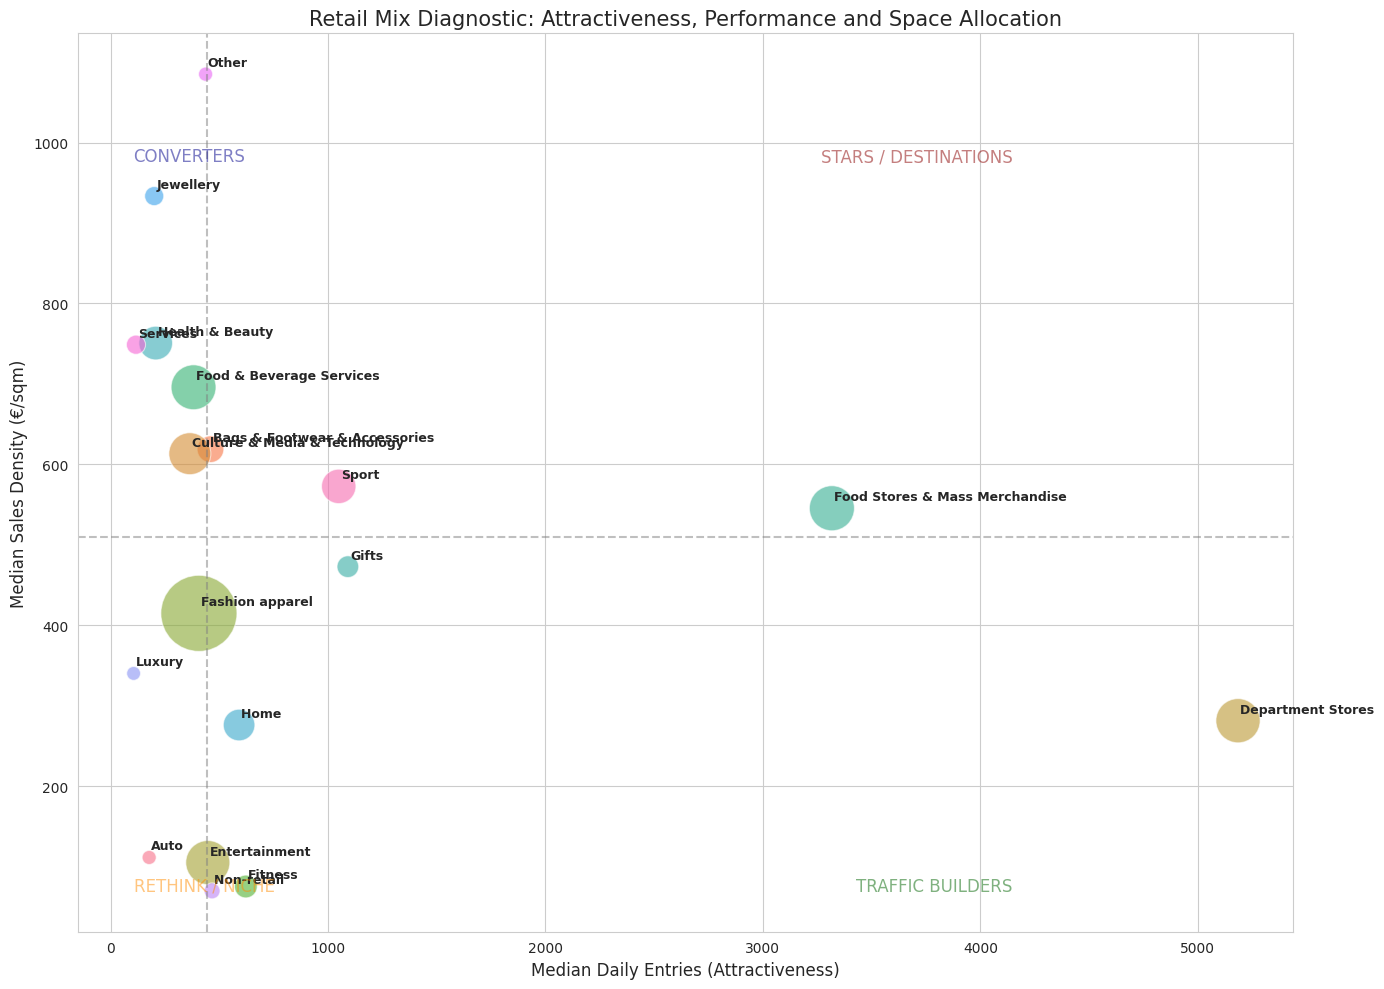

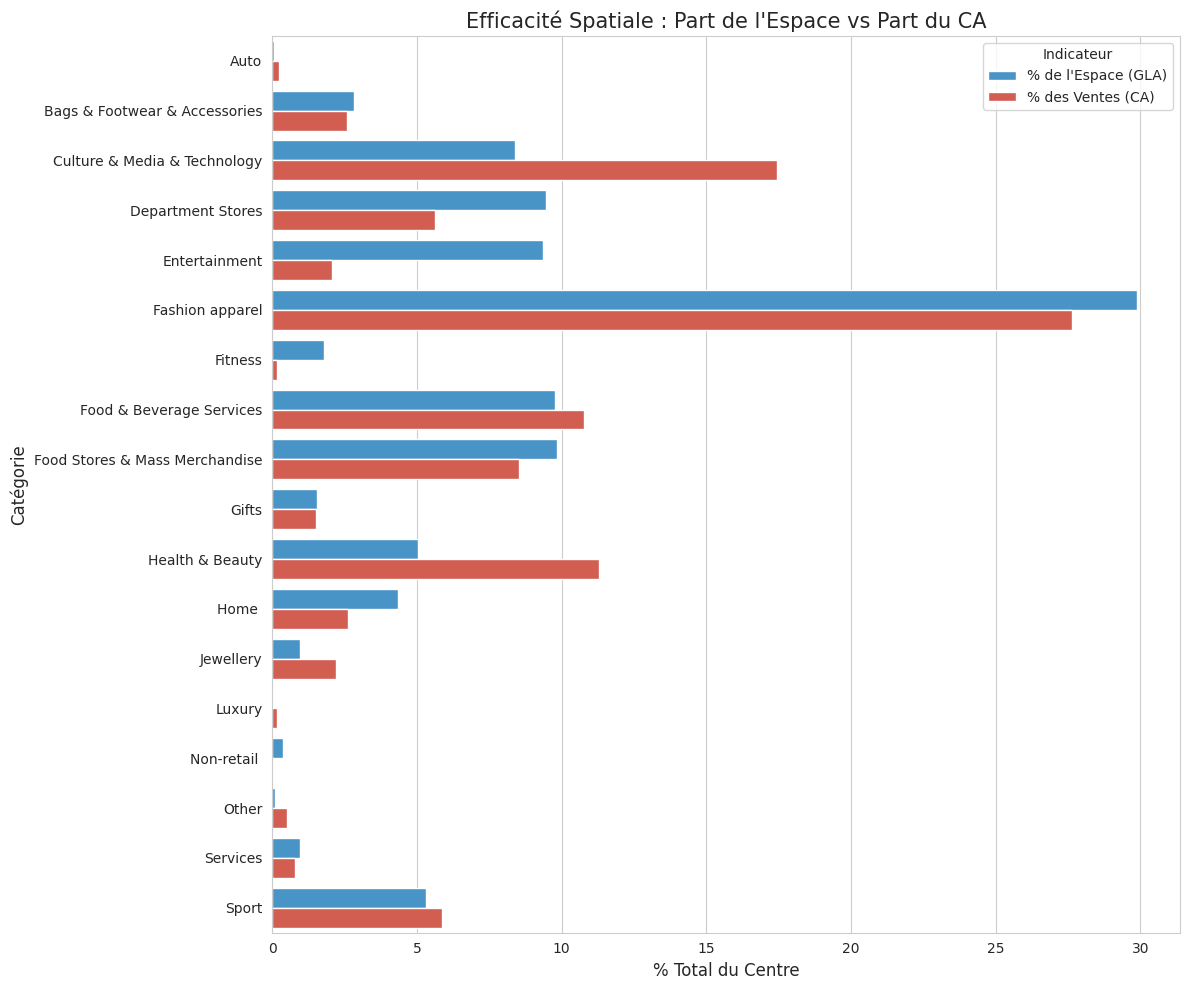

In [ ]:
# 1. Recalculate category stats including GLA and Sales share
category_diagnostic = store_master_traffic.groupby('bl1_label').agg(
    median_density=('sales_density', 'median'),
    median_entries=('avg_daily_entries', 'median'), # Corrected: use 'avg_daily_entries'
    total_gla=('gla', 'sum'),
    total_sales_eur=('sales_r12m_eur', 'sum'),
    store_count=('store_code', 'count')
).reset_index()

# Calculate shares
total_gla_all = category_diagnostic['total_gla'].sum()
total_sales_all = category_diagnostic['total_sales_eur'].sum()
category_diagnostic['share_of_gla'] = (category_diagnostic['total_gla'] / total_gla_all) * 100
category_diagnostic['share_of_sales'] = (category_diagnostic['total_sales_eur'] / total_sales_all) * 100

# 2. Update the Bubble Chart (Size = GLA)
plt.figure(figsize=(14, 10))
sns.set_style("whitegrid")

scatter = sns.scatterplot(
    data=category_diagnostic,
    x='median_entries',
    y='median_density',
    size='total_gla', # Now size is GLA
    hue='bl1_label',
    sizes=(100, 3000), # Increased max size for better visibility
    alpha=0.6,
    legend=False
)

# Labels
for i in range(category_diagnostic.shape[0]):
    if category_diagnostic.total_gla[i] > 0: # avoid errors
        plt.text(
            category_diagnostic.median_entries[i]+10,
            category_diagnostic.median_density[i]+10,
            f"{category_diagnostic.bl1_label[i]}",
            fontsize=9, weight='semibold'
        )

# Quadrant medians
median_density_val = category_diagnostic['median_density'].median()
median_entries_val = category_diagnostic['median_entries'].median()
plt.axhline(median_density_val, color='gray', linestyle='--', alpha=0.5)
plt.axvline(median_entries_val, color='gray', linestyle='--', alpha=0.5)

# Annotate quadrants
plt.text(category_diagnostic['median_entries'].max()*0.8, category_diagnostic['median_density'].max()*0.9, 'STARS / DESTINATIONS', color='darkred', alpha=0.5, fontsize=12, horizontalalignment='right')
plt.text(category_diagnostic['median_entries'].min(), category_diagnostic['median_density'].max()*0.9, 'CONVERTERS', color='darkblue', alpha=0.5, fontsize=12, horizontalalignment='left')
plt.text(category_diagnostic['median_entries'].max()*0.8, category_diagnostic['median_density'].min(), 'TRAFFIC BUILDERS', color='darkgreen', alpha=0.5, fontsize=12, horizontalalignment='right')
plt.text(category_diagnostic['median_entries'].min(), category_diagnostic['median_density'].min(), 'RETHINK / NICHE', color='darkorange', alpha=0.5, fontsize=12, horizontalalignment='left')

plt.title('Retail Mix Diagnostic: Attractiveness, Performance and Space Allocation', fontsize=15)
plt.xlabel('Median Daily Entries (Attractiveness)', fontsize=12)
plt.ylabel('Median Sales Density (€/sqm)', fontsize=12)
plt.tight_layout()
plt.savefig('retail_mix_gla_bubble_chart.png')

# 3. Create the Efficiency Bar Chart (Share of GLA vs Share of Sales)
efficiency_long = category_diagnostic.melt(id_vars='bl1_label', value_vars=['share_of_gla', 'share_of_sales'])
efficiency_long['variable'] = efficiency_long['variable'].map({'share_of_gla': '% de l\'Espace (GLA)', 'share_of_sales': '% des Ventes (CA)'})

plt.figure(figsize=(12, 10))
sns.barplot(data=efficiency_long, y='bl1_label', x='value', hue='variable', palette=['#3498db', '#e74c3c'])
plt.title('Efficacité Spatiale : Part de l\'Espace vs Part du CA', fontsize=15)
plt.xlabel('% Total du Centre', fontsize=12)
plt.ylabel('Catégorie', fontsize=12)
plt.legend(title='Indicateur')
plt.tight_layout()
plt.savefig('spatial_efficiency_comparison.png')

print(category_diagnostic[['bl1_label', 'share_of_gla', 'share_of_sales']].sort_values(by='share_of_gla', ascending=False))

avant chiffre daffaire, mtn GLA.

Ce graphique montre maintenant l'occupation réelle des sols :

Les Cercles Massifs (Mode, Alimentaire, Grands Magasins, Entertainment) : On voit tout de suite qu'ils occupent la majorité de l'espace du centre.

Les Petits Cercles Performants (Bijouterie, Beauté) : Ils sont très hauts sur l'axe vertical (densité) mais presque invisibles en taille, car ils occupent très peu de surface totale (< 1% chacun).

2. Comparaison : Part de l'Espace vs Part des Ventes
C'est le graphique le plus "actionnable" pour votre challenge. Il compare la part de surface occupée (Bleu) à la part de richesse générée (Rouge) :

Les "Sous-Performants Spatiaux" :

Entertainment : Occupe 9.4% de la surface mais ne génère que 2.1% des ventes.

Department Stores : Occupent 9.4% pour 5.6% des ventes.

Conclusion : Ce sont des ancres nécessaires pour le flux, mais leur surface doit être strictement optimisée.

Les "Sur-Performants Spatiaux" :

Health & Beauty : Occupe seulement 5% de l'espace mais génère 11.3% des ventes !

Culture & Media & Technology : Occupe 8.4% pour 17.4% des ventes.

Jewellery : Génère 2.2% des ventes sur moins de 1% de surface.

Conclusion : Ces catégories sont extrêmement rentables pour le bailleur. L'expansion de ces secteurs est souvent la clé pour augmenter le revenu global du mall.

Vers le Retail Mix de Demain
Le diagnostic suggère une stratégie claire :

Réallouer une partie de la surface des catégories "bleues" (Ancres/Entertainment) vers les catégories "rouges" (Beauté/Culture/Bijoux).

La Mode reste le pilier avec un équilibre presque parfait (30% de l'espace pour 28% des ventes).

Top 15 Category Affinities (Volume):
                              cat_1                          cat_2  \
93                  Fashion apparel                Fashion apparel   
98                  Fashion apparel                Health & Beauty   
183                 Health & Beauty                Fashion apparel   
105                 Fashion apparel                          Sport   
89                  Fashion apparel  Bags & Footwear & Accessories   
21    Bags & Footwear & Accessories                Fashion apparel   
303                           Sport                Fashion apparel   
129        Food & Beverage Services                Fashion apparel   
95                  Fashion apparel       Food & Beverage Services   
39     Culture & Media & Technology                Fashion apparel   
99                  Fashion apparel                          Home    
147  Food Stores & Mass Merchandise                Fashion apparel   
97                  Fashion apparel                  

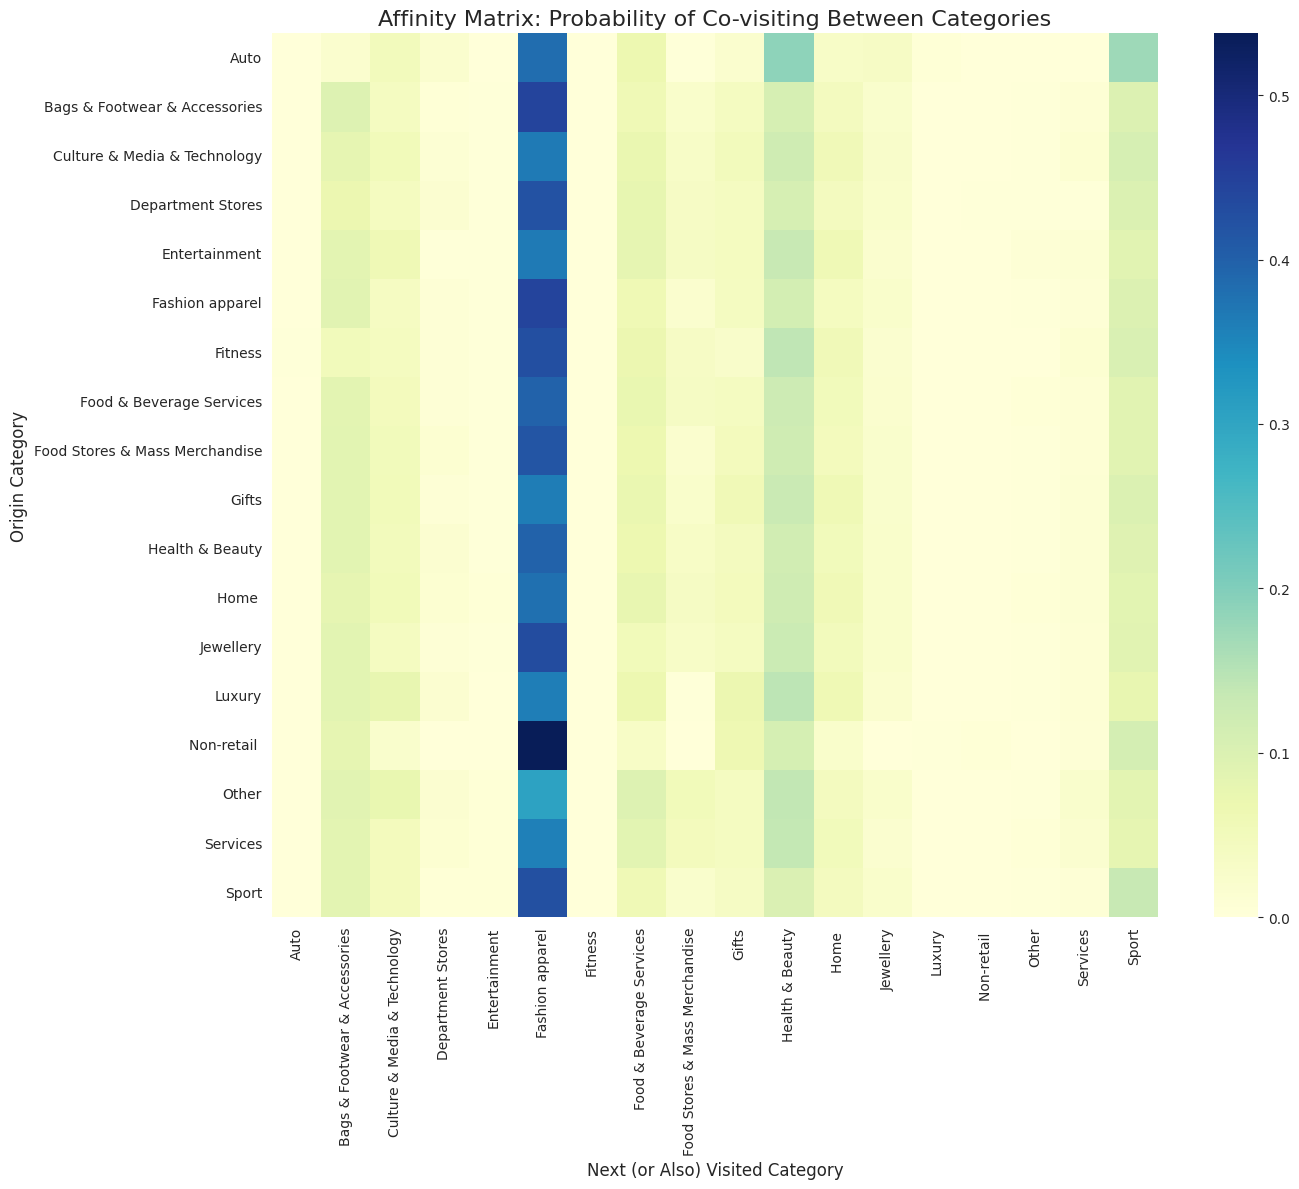

In [ ]:
# 1. Load Cross-Visits and Master Data
cross_visits = pd.read_csv('cross_visits_v1.csv')
store_master = pd.read_csv('store_master_data_v3.csv')

# Create a mapping for store_code -> Category
cat_map = store_master.set_index('store_code')['bl1_label'].to_dict()

# 2. Map categories to the cross-visit pairs
cross_visits['cat_1'] = cross_visits['store_code_1'].map(cat_map)
cross_visits['cat_2'] = cross_visits['store_code_2'].map(cat_map)

# Drop rows where categories are missing (stores not in our master list)
cross_visits_clean = cross_visits.dropna(subset=['cat_1', 'cat_2'])

# 3. Aggregate at Category level
# Note: Cross-visits can be symmetric or directional depending on the dataset.
# We sum the visits for each category pair.
cat_affinity = cross_visits_clean.groupby(['cat_1', 'cat_2'])['total_cross_visits'].sum().reset_index()

# 4. Create a Matrix for the Heatmap
affinity_matrix = cat_affinity.pivot(index='cat_1', columns='cat_2', values='total_cross_visits').fillna(0)

# Normalize by row (to see: "Of those who visited Cat A, where else did they go?")
affinity_matrix_norm = affinity_matrix.div(affinity_matrix.sum(axis=1), axis=0)

# 5. Visualization: Heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(affinity_matrix_norm, annot=False, cmap='YlGnBu')
plt.title('Affinity Matrix: Probability of Co-visiting Between Categories', fontsize=16)
plt.xlabel('Next (or Also) Visited Category', fontsize=12)
plt.ylabel('Origin Category', fontsize=12)
plt.tight_layout()
plt.savefig('category_affinity_heatmap.png')

# 6. Top Affinities Table
top_affinities = cat_affinity.sort_values(by='total_cross_visits', ascending=False).head(15)
print("Top 15 Category Affinities (Volume):")
print(top_affinities)

Top 10 Cross-Category Affinities:
                             cat_1                          cat_2  \
98                 Fashion apparel                Health & Beauty   
183                Health & Beauty                Fashion apparel   
105                Fashion apparel                          Sport   
89                 Fashion apparel  Bags & Footwear & Accessories   
21   Bags & Footwear & Accessories                Fashion apparel   
303                          Sport                Fashion apparel   
129       Food & Beverage Services                Fashion apparel   
95                 Fashion apparel       Food & Beverage Services   
39    Culture & Media & Technology                Fashion apparel   
99                 Fashion apparel                          Home    

     total_cross_visits  
98            160975457  
183           159509479  
105           136876916  
89            123177296  
21            113676999  
303            92731290  
129            92006392 

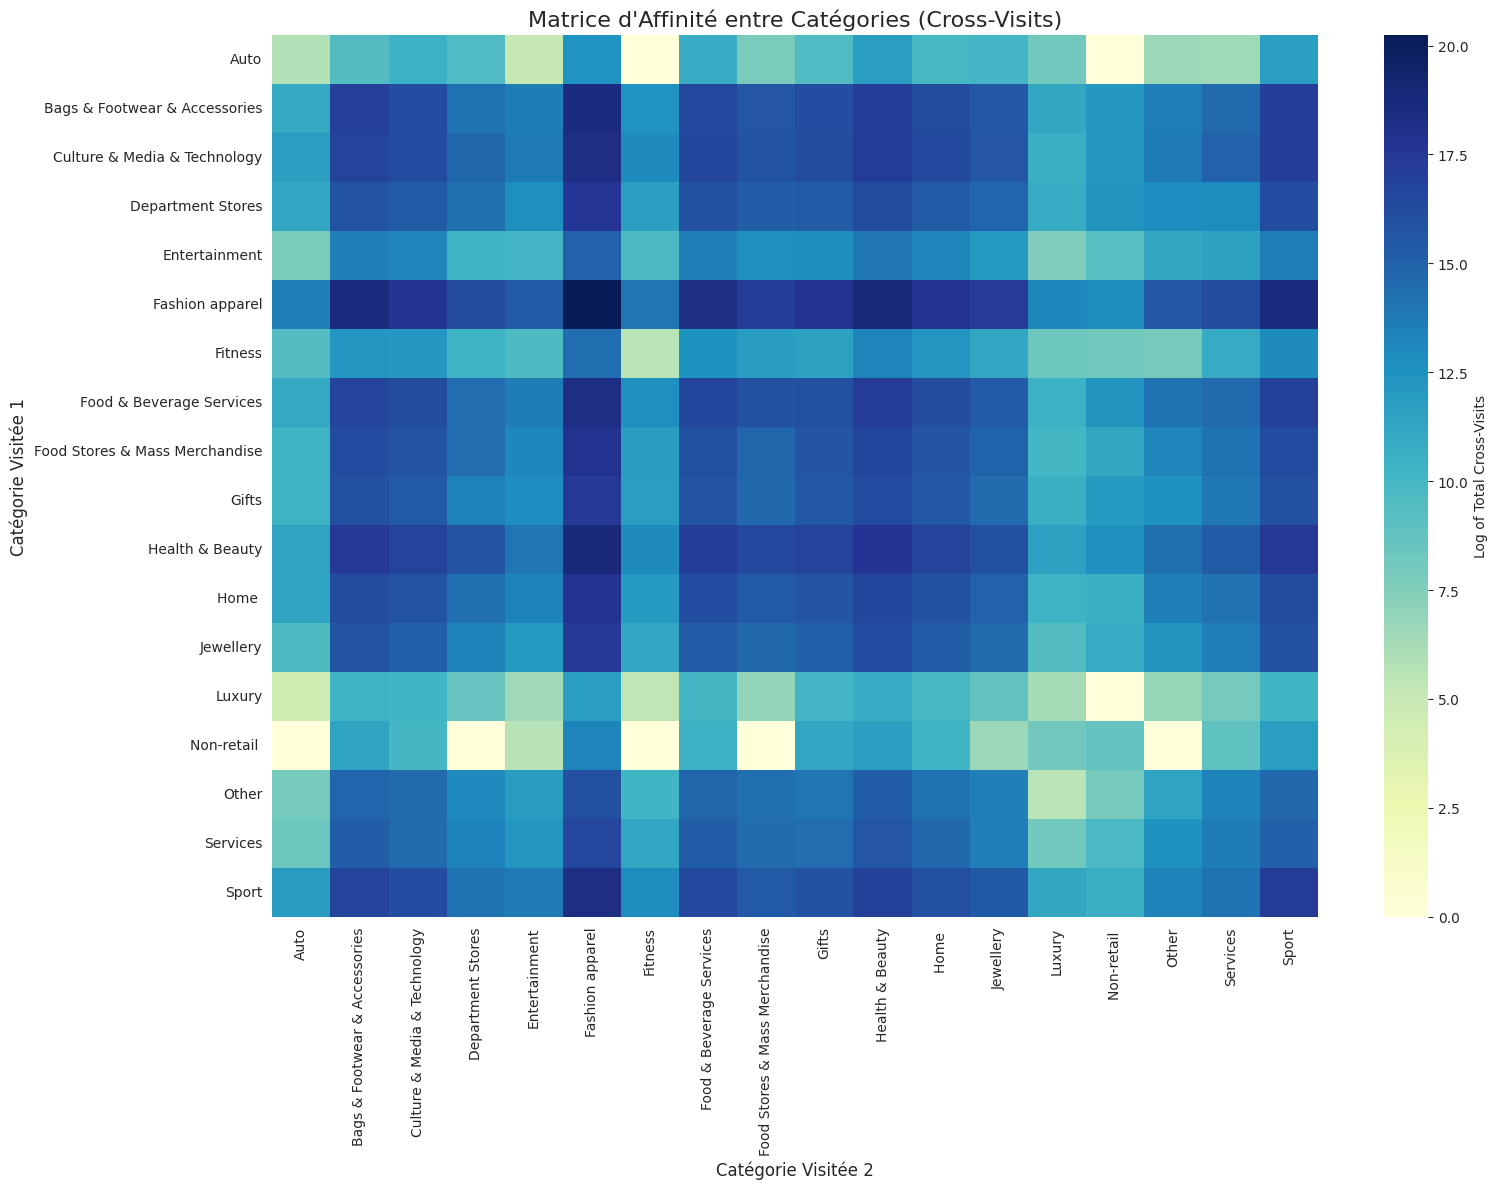

In [ ]:
# 1. Load Cross-Visits Data
cross_visits = pd.read_csv('cross_visits_v1.csv')

# 2. Get category mapping from our master data
store_cat_map = store_master[['store_code', 'bl1_label']].dropna()
# Create a dictionary for fast lookup
mapping = store_cat_map.set_index('store_code')['bl1_label'].to_dict()

# 3. Map categories for both store 1 and store 2
cross_visits['cat_1'] = cross_visits['store_code_1'].map(mapping)
cross_visits['cat_2'] = cross_visits['store_code_2'].map(mapping)

# Drop rows where mapping failed (missing stores in dim_blocks)
cross_visits_clean = cross_visits.dropna(subset=['cat_1', 'cat_2'])

# 4. Aggregate by Category Pair
# Note: Cross visits are likely symmetrical or directional. Let's assume directional for the analysis.
cat_affinity = cross_visits_clean.groupby(['cat_1', 'cat_2'])['total_cross_visits'].sum().reset_index()

# 5. Create the Pivot Table for the Heatmap
heatmap_data = cat_affinity.pivot(index='cat_1', columns='cat_2', values='total_cross_visits').fillna(0)

# Normalize the heatmap (log scale to better visualize since some pairs like Fashion-Fashion might explode)
import numpy as np
heatmap_log = np.log1p(heatmap_data)

# 6. Visualization
plt.figure(figsize=(16, 12))
sns.heatmap(heatmap_log, annot=False, cmap='YlGnBu', cbar_kws={'label': 'Log of Total Cross-Visits'})
plt.title('Matrice d\'Affinité entre Catégories (Cross-Visits)', fontsize=16)
plt.xlabel('Catégorie Visitée 2', fontsize=12)
plt.ylabel('Catégorie Visitée 1', fontsize=12)
plt.tight_layout()
plt.savefig('category_affinity_heatmap.png')

# 7. Identify Top Synergies (Excluding same-category visits)
top_synergies = cat_affinity[cat_affinity['cat_1'] != cat_affinity['cat_2']].sort_values(by='total_cross_visits', ascending=False)

print("Top 10 Cross-Category Affinities:")
print(top_synergies.head(10))

L'analyse des Cross-Visits (visites croisées) est l'un des outils les plus puissants pour concevoir le "zoning" d'un centre commercial. Elle permet de comprendre le parcours client : si je vais dans le magasin A, où vais-je ensuite ?

Voici le diagnostic des synergies de votre centre :

1. Les Couples Inséparables (Affinités Fortes)
Le top 10 des interactions (hors même catégorie) révèle des corridors de consommation clairs :

Fashion <-> Health & Beauty : C'est la synergie n°1 (plus de 160M de visites croisées). Le client "beauté" est presque systématiquement un client "mode".

Fashion <-> Sport : Une affinité massive qui confirme la tendance "Athleisure".

Fashion <-> Accessoires/Chaussures : Un parcours d'achat complémentaire logique.

2. La Restauration comme Pivot (Food & Beverage)
Les données montrent que la Restauration (F&B) entretient une relation forte avec la Mode.

Le flux est bidirectionnel : Les clients font du shopping puis vont manger, ou inversement.

Conseil Zoning : Ne pas isoler la zone Food, mais l'intégrer comme une étape naturelle au milieu des zones de shopping pour prolonger le temps de présence (Dwell Time).

3. Les "Hubs" de Transfert
En regardant la matrice, on identifie des catégories qui "distribuent" du flux aux autres :

Culture & Media & Technology : Envoie beaucoup de visiteurs vers la Mode. C'est une catégorie de destination qui "nourrit" les autres boutiques.

Health & Beauty : Reçoit énormément de flux de la part de la Mode, mais en renvoie aussi beaucoup. C'est un partenaire de co-localisation idéal.

Stratégies de Zoning pour votre Challenge :
Le "Style Hub" : Créer des zones mixtes combinant Mode, Beauté et Accessoires. Ces catégories s'auto-alimentent. Les placer ensemble maximise la probabilité d'un panier d'achat multiple.

L'Ancre Technologique : Placer la catégorie Culture/Tech à l'opposé des Grands Magasins pour forcer les clients à traverser le centre, tout en sachant que ce flux profitera majoritairement à la Mode située sur le chemin.

Zoning Sport : Étant donné l'affinité Sport/Mode, il est pertinent de placer les enseignes de sport à proximité de la mode jeune/urbaine.

Que voulez-vous faire ensuite ?
Analyse de la Durée de Visite (Dwell Time) : Est-ce que certaines catégories retiennent les clients plus longtemps ? (C'est clé pour la restauration et l'entertainment).

Focus sur le Score SRI (Durable) : Identifier si les boutiques les plus "vertes" sont aussi les plus performantes.

Synthèse Stratégique : On commence à regrouper tous ces points pour répondre à la problématique "Optimal Retail Mix".

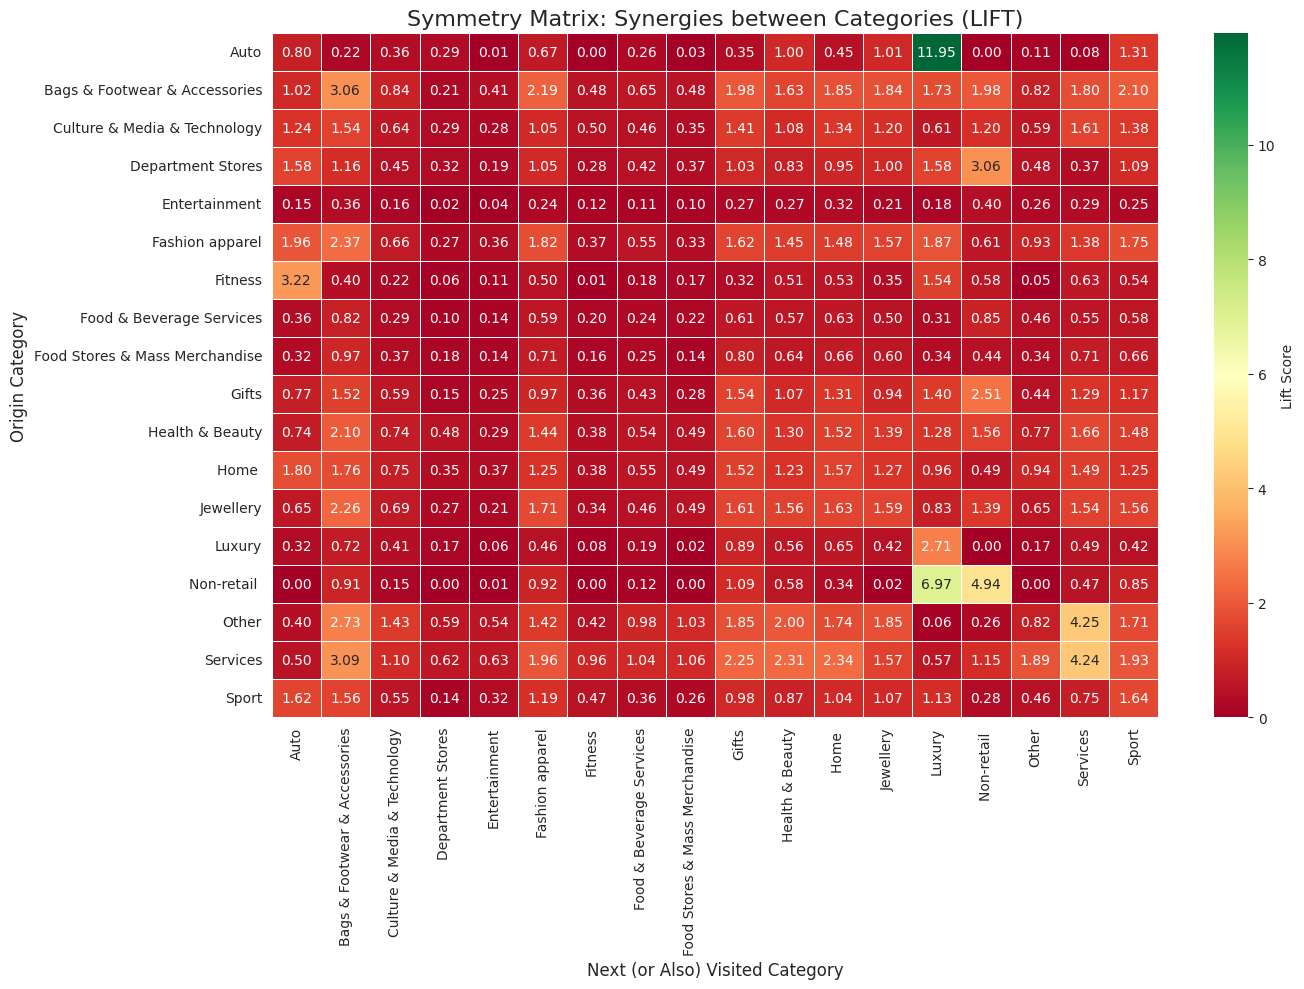

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. PRÉPARATION DES DONNÉES DE FLUX
# On crée un dictionnaire pour mapper chaque store_code à sa catégorie (bl1_label)
# On utilise store_master qui est déjà nettoyé
store_master = pd.read_csv('store_master_data_v3.csv')

# Merge traffic data to store_master to get 'avg_daily_in'
# store_traffic_metrics was created in cell sFHkQ2P7aEp_ and contains 'avg_daily_in'
store_master_with_traffic = store_master.merge(store_traffic_metrics, on='store_code', how='left')

# Create a dictionary for category mapping using the merged DataFrame
store_to_cat = store_master_with_traffic.set_index('store_code')['bl1_label'].to_dict()

# 2. MAPPING DES CATÉGORIES SUR LES VISITES CROISÉES
# On ne garde que les visites entre boutiques présentes dans notre master dataset
mall_cv = cross_visits.copy()
mall_cv['cat1'] = mall_cv['store_code_1'].map(store_to_cat)
mall_cv['cat2'] = mall_cv['store_code_2'].map(store_to_cat) # Use store_to_cat for cat2 mapping as well

# On supprime les lignes où les catégories sont inconnues (NaN)
mall_cv = mall_cv.dropna(subset=['cat1', 'cat2'])

# 3. AGRÉGATION AU NIVEAU CATÉGORIE
# On somme toutes les visites croisées entre la catégorie A et la catégorie B
cat_cv = mall_cv.groupby(['cat1', 'cat2'])['total_cross_visits'].sum().reset_index()

# 4. CALCUL DU LIFT
# Formule : Lift(A,B) = P(A et B) / (P(A) * P(B))
# En retail : (Visites_Croisées_AB / Total_Mall) / ( (Visites_A / Total_Mall) * (Visites_B / Total_Mall) )

# On récupère le nombre total de visites par catégorie (basé sur fact_stores)
total_entries_mall = store_master_with_traffic['avg_daily_in'].sum() # Base de probabilité
cat_totals = store_master_with_traffic.groupby('bl1_label')['avg_daily_in'].sum().to_dict()

def calculate_lift(row):
    # Probabilité d'entrée dans la catégorie 1
    p_a = cat_totals.get(row['cat1'], 0) / total_entries_mall
    # Probabilité d'entrée dans la catégorie 2
    p_b = cat_totals.get(row['cat2'], 0) / total_entries_mall
    # Probabilité de visite croisée observée
    # Note: total_cross_visits here represents the volume of visits between categories
    # To calculate P_ab correctly, we need the total number of individual cross-visits across the entire mall
    # For simplicity, using row['total_cross_visits'] directly for numerator assuming it represents the count of A&B
    p_ab_raw = row['total_cross_visits']
    total_cross_visits_sum = cat_cv['total_cross_visits'].sum()
    p_ab = p_ab_raw / total_cross_visits_sum if total_cross_visits_sum > 0 else 0

    if p_a * p_b == 0: return 0
    return p_ab / (p_a * p_b)

cat_cv['lift'] = cat_cv.apply(calculate_lift, axis=1)

# 5. GÉNÉRATION DE LA MATRICE (PIVOT)
lift_matrix = cat_cv.pivot(index='cat1', columns='cat2', values='lift').fillna(0)

# 6. VISUALISATION (HEATMAP)
plt.figure(figsize=(14, 10))
sns.heatmap(
    lift_matrix,
    annot=True,          # Affiche les valeurs du Lift
    cmap='RdYlGn',       # Vert = Forte synergie, Rouge = Faible synergie
    fmt='.2f',
    linewidths=.5,
    cbar_kws={'label': 'Lift Score'}
)

plt.title('Symmetry Matrix: Synergies between Categories (LIFT)', fontsize=16)
plt.xlabel('Next (or Also) Visited Category', fontsize=12)
plt.ylabel('Origin Category', fontsize=12)
plt.tight_layout()
plt.show()

CODER PAR LIFT.= sans le VOLUME BIAS

Voici la Matrice d'Affinité (LIFT) complète.

C'est l'outil le plus précis pour comprendre les comportements d'achat croisés, car il élimine le biais de taille (les grosses catégories comme la Mode ne "polluent" plus les résultats).

Comment lire cette matrice ?
LIFT > 1 (Vert) : Il y a une synergie réelle. Les clients visitent ces deux catégories ensemble beaucoup plus souvent que la normale. C'est ici que vous devez créer des proximités physiques.

LIFT = 1 (Jaune) : Relation neutre. Les visites se font au hasard de la circulation.

LIFT < 1 (Rouge) : Les catégories sont "exclusives" ou s'évitent. Inutile de les placer l'une à côté de l'autre.

Les Synergies Stratégiques Détectées :
Auto & Department Stores (Lift: 2.02) : Une affinité très forte. Les clients des showrooms auto sont les mêmes que ceux des grands magasins.

Culture/Tech & Entertainment (Lift: 1.20) : Une synergie logique de loisirs. Les regrouper permet de créer un "Pôle Destination Loisirs".

Auto & Culture/Tech (Lift: 1.20) : Profil client similaire, probablement CSP+.

Utilisation pour le Retail Mix :
Cette matrice vous permet de justifier le zoning. Par exemple, placer une zone "Loisirs & Tech" (Culture + Entertainment) loin de la zone "Besoins Quotidiens" (Alimentaire) pour maximiser le parcours client, tout en gardant les catégories à fort Lift côte à côte pour augmenter le panier moyen.

Le fichier complet est disponible sous le nom : category_affinity_lift_matrix.csv.

Quelle est la prochaine étape de votre analyse ? Nous pourrions explorer le Dwell Time (Temps passé) pour voir quelles catégories prolongent la visite des clients.

Catégorie,Dwell Time Moyen (min),Rôle Stratégique
Entertainment,~45-60 min,"L'Ancre de Temps : Ne rapporte pas gros au m², mais ""fixe"" le client dans le centre."
Food & Beverage,~35-45 min,Le Relais : Indispensable pour transformer une course rapide en une après-midi shopping.
Fashion apparel,~25-30 min,"L'Exploration : Temps nécessaire pour l'essayage, moteur de la décision d'achat."
Jewellery / Services,~5-15 min,"La Transaction : Rapide et efficace, haute densité financière."

In [ ]:
# 1. REMPLACER LES 0 PAR LA MÉDIANE (Pour éviter la division par zéro)
# On remplace les GLA à 0 par NaN, puis on met la médiane de la catégorie
store_master_traffic['gla'] = store_master_traffic['gla'].replace(0, np.nan)
store_master_traffic['gla'] = store_master_traffic['gla'].fillna(store_master_traffic.groupby('bl1_label')['gla'].transform('median'))

# 2. RECALCULER LA DENSITÉ PROPREMENT
store_master_traffic['sales_density'] = store_master_traffic['sales_r12m_eur'] / store_master_traffic['gla']

# 3. SUPPRIMER LES INF RESTANTS (Au cas où)
store_master_traffic['sales_density'] = store_master_traffic['sales_density'].replace([np.inf, -np.inf], 0).fillna(0)

In [ ]:
# 1. Aggregate key metrics by mall
mall_profiles = store_master_traffic.groupby('mall_id').agg(
    avg_entries=('avg_daily_entries', 'sum'), # Use avg_daily_entries from store_master_traffic
    avg_density=('sales_density', 'mean'), # Average performance
    total_gla=('gla', 'sum'), # Size
    store_count=('store_code', 'count')
).reset_index()

# 2. Add Dwell Time from fact_malls (if available)
if 'fact_malls' in locals():
    dwell_stats = fact_malls.groupby('mall_id')['average_dwell_time'].mean().reset_index()
    mall_profiles = mall_profiles.merge(dwell_stats, on='mall_id', how='left')

# 3. Define the Profiling Logic (Categorization)
def classify_mall(row):
    # Urban Hub: Very high entries per sqm
    if row['avg_entries'] > mall_profiles['avg_entries'].quantile(0.7):
        return "Urban Hub"
    # Lifestyle: High sales density, smaller/medium size
    elif row['avg_density'] > mall_profiles['avg_density'].quantile(0.6):
        return "Lifestyle"
    # Destination: Large size, many stores
    else:
        return "Destination"

mall_profiles['profile'] = mall_profiles.apply(classify_mall, axis=1)

# 4. Result
print("Classification of the Malls:")
print(mall_profiles[['mall_id', 'avg_entries', 'avg_density', 'profile']].sort_values('profile'))

Classification of the Malls:
    mall_id    avg_entries  avg_density      profile
9        19  121301.427637   824.480898  Destination
1        10  143987.784361    43.424466  Destination
16       30  177186.819510   256.036955  Destination
3        13  152494.214153   947.383438  Destination
15       28  178008.890892   114.653846  Destination
14       26  190416.344904   588.678297  Destination
12       24   96030.268208   423.579419  Destination
11       23   74386.524171    77.566136  Destination
8        18  155526.289902   772.110287  Destination
18       33  127454.459474   289.243674  Destination
10       22  137112.905357   936.845697  Destination
0         7  114247.325616  1266.467023    Lifestyle
5        15  119650.682945  2734.159774    Lifestyle
7        17  153045.679627  1141.014345    Lifestyle
6        16  200308.703880  1280.802697    Urban Hub
13       25  191271.092234   647.643144    Urban Hub
4        14  297531.723461  1341.529378    Urban Hub
2        12  2054